# Results 

## Description
In this notebook, we will compare multiple classifiers from different perspectives:
1. Accuracy vs. Imbalance
2. Risk curves
3. Losses vs. Iterations

The following classifiers are considered:
 - Bagging
 - AdaBoost
 - AdaCost
 - Boosting SVM?
 - AdaMEC
 - XGBoost



In [36]:
# Libraries
from classifiers import *
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
# from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

In [37]:
# Functions (if any)


### Load Data

In [38]:
scaler = StandardScaler()
data = pd.read_pickle("./data_no_cathegorical.pkl")

X = data.values[:,:-1]
scaler.fit(X)
X = scaler.transform(X)
Y = data.values[:,-1]

# Split data into train and test sets
seed = 10
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# Labels for this algortihm has to be either 1 or -1
y_train = np.where(y_train < 0.5, -1, 1)
y_test = np.where(y_test < 0.5, -1, 1)

## Graph 1: Accuracy vs. Imbalance

In [39]:
# Get priors
prior0 = len(np.where(y_train==-1)[0])/len(y_train)
prior1 = len(np.where(y_train==1)[0])/len(y_train)
print(prior0,prior1)

0.7293164556962025 0.2706835443037975


In [40]:
# We will undersample class -1 until we revert the imbalance
X_train_0 = X_train[np.where(y_train==-1)[0],:]
X_train_1 = X_train[np.where(y_train==1)[0],:]
y_train_0 = y_train[np.where(y_train==-1)[0]]
y_train_1 = y_train[np.where(y_train==1)[0]]

x_train_sets = [np.r_[X_train_0[:int(len(X_train_0)*pctg),:], X_train_1] for pctg in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]]
y_train_sets = [np.r_[y_train_0[:int(len(X_train_0)*pctg)], y_train_1] for pctg in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]]

# Get new imbalances
imbalances = []
for y_train in y_train_sets:
    imbalances.append(len(np.where(y_train==-1)[0])/len(y_train))
print(imbalances)

[0.7080124528920203, 0.6830873199359773, 0.6534871661913404, 0.6178152702316271, 0.5739560089257252, 0.5186819123075538, 0.4469845867383883, 0.350109409190372, 0.21220159151193635]


In [41]:
# Get classifier for each imbalanced dataset
# ADABOOST
AdaBoost_set = [AdaBoostClassifier(n_estimators=100).fit(X_train,y_train) for X_train,y_train in zip(x_train_sets, y_train_sets)]
# AdaBoost_set = [AdaboostClassifier().fit(X_train,y_train) for X_train,y_train in zip(x_train_sets, y_train_sets)]

print('AdaBoost - OK')

AdaBoost - OK


In [42]:
# ADACOST
AdaCost_set = []
for X_train,y_train in zip(x_train_sets, y_train_sets):
    ac = AdaCost(n_iterations=100)
    ac.fit(X_train,y_train,cost=0.4)
    AdaCost_set.append(ac)
     
print('AdaCost - OK')

AdaCost - OK


In [43]:
# ADAMEC
AdaMEC_set = [AdaMEC(n_iterations=100).fit(X_train,y_train) for X_train,y_train in zip(x_train_sets, y_train_sets)]
print('AdaMEC - OK')


AdaMEC - OK


In [44]:
# XGBOOST
XGBoost_set = [XGBClassifier().fit(X_train,y_train) for X_train,y_train in zip(x_train_sets, y_train_sets)]
print('XGBoost - OK')

XGBoost - OK


In [45]:
# Bagging
Bagging_set = []
for X_train,y_train in zip(x_train_sets, y_train_sets):
    bagging_model = Bagging_classifier(type_classifier="SVM")
    bagging_model.fit(X_train,y_train)
    Bagging_set.append(bagging_model)
     
print('Bagging - OK')

Bagging - OK


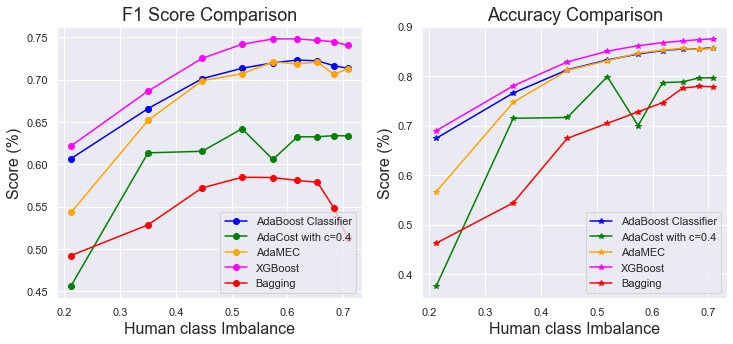

In [46]:
classifier_label = ['AdaBoost Classifier', 'AdaCost with c=0.4','AdaMEC','XGBoost','Bagging']
classifier_color = ['blue','green','orange','magenta','red']
cont = 0
f = plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for classifiers in [AdaBoost_set, AdaCost_set, AdaMEC_set, XGBoost_set, Bagging_set]:
    acc = []
    f1 = []
    # Calculate accuracies
    for classifier in classifiers:
        acc.append(accuracy_score(classifier.predict(X_test),y_test))
        f1.append(f1_score(classifier.predict(X_test),y_test))
        
    ax1.plot(imbalances, f1,'-o', color = classifier_color[cont],label = classifier_label[cont])
    ax2.plot(imbalances, acc,'-*', color = classifier_color[cont],label = classifier_label[cont])
    
    cont += 1

ax1.set_title('F1 Score Comparison', fontsize = 18)
ax2.set_title('Accuracy Comparison', fontsize = 18)
ax1.set_xlabel('Human class Imbalance', fontsize = 16)
ax2.set_xlabel('Human class Imbalance', fontsize = 16)
ax1.set_ylabel('Score (%)', fontsize = 16)
ax2.set_ylabel('Score (%)', fontsize = 16)
ax1.legend()
ax2.legend()
plt.savefig('../WriteUp/pictures/Imbalance_Comparison.png')
plt.show()


<Figure size 432x288 with 0 Axes>

### Plot

In [13]:
# TODO: Add bagging
# SVM?

### Graph 2: Risk curves

In [47]:
scaler = StandardScaler()
data = pd.read_pickle("./data_no_cathegorical.pkl")

X = data.values[:,:-1]
scaler.fit(X)
X = scaler.transform(X)
Y = data.values[:,-1]

# Split data into train and test sets
seed = 10
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# Labels for this algortihm has to be either 1 or -1
y_train = np.where(y_train < 0.5, -1, 1)
y_test = np.where(y_test < 0.5, -1, 1)

In [48]:
n_learners_list = [1,5,10,20,50,75,100,150,200]

In [49]:
# ADABOOST
# AdaBoost_set = [AdaBoostClassifier(n_estimators = n_learners).fit(X_train,y_train) for n_learners in n_learners_list]
AdaBoost_set = []
for n_learners in n_learners_list:
    ab = AdaboostClassifier(n_iterations=n_learners)
    ab.fit(X_train,y_train)
    AdaBoost_set.append(ab)
    
print('AdaBoost - OK')

# ADACOST
AdaCost_set = []
for n_learners in n_learners_list:
    ac = AdaCost(n_iterations=n_learners)
    ac.fit(X_train,y_train,cost=-0.4)
    AdaCost_set.append(ac)
     
print('AdaCost - OK')

# ADAMEC
AdaMEC_set = [AdaMEC(n_iterations=n_learners).fit(X_train,y_train) for n_learners in n_learners_list]
print('AdaMEC - OK')

# XGBOOST
XGBoost_set = [XGBClassifier(n_estimators=n_learners).fit(X_train,y_train) for n_learners in n_learners_list]
print('XGBoost - OK')

# Bagging
Bagging_set = []
for n_learners in n_learners_list:
    bagging_model = Bagging_classifier(type_classifier="SVM",n_iterations = n_learners)
    bagging_model.fit(X_train,y_train)
    Bagging_set.append(bagging_model)
     
print('Bagging - OK')

AdaBoost - OK
AdaCost - OK
AdaMEC - OK
XGBoost - OK
Bagging - OK


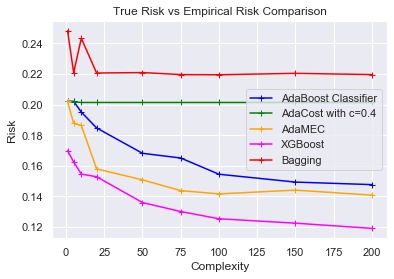

In [50]:
classifier_label = ['AdaBoost Classifier', 'AdaCost with c=0.4','AdaMEC','XGBoost','Bagging']
classifier_color = ['blue','green','orange','magenta','red']
cont = 0
plt.figure()
for classifiers in [AdaBoost_set, AdaCost_set, AdaMEC_set, XGBoost_set, Bagging_set]:
    empirical_risk_list = []
    true_risk_list = []
    # Calculate accuracies
    for classifier in classifiers:
        
        incorrect_pred_emp = 0
        incorrect_pred_true = 0
        
        pred_train = classifier.predict(X_train)
        
        for item in range(np.shape(X_train)[0]):
            
            if pred_train[item] != y_train[item]:
                incorrect_pred_emp = incorrect_pred_emp + 1
        
        emp_risk =  incorrect_pred_emp/len(X_train)
        
        
        pred_test = classifier.predict(X_test)
        
        for item in range(np.shape(X_test)[0]):
            
            if pred_test[item] != y_test[item]:
                incorrect_pred_true = incorrect_pred_true + 1
        
        true_risk =  incorrect_pred_true/len(X_test)       
        
        
        empirical_risk_list.append(emp_risk)
        true_risk_list.append(true_risk)
        
        
    #plt.plot(n_learners_list, empirical_risk_list,'-o', color = classifier_color[cont],label = classifier_label[cont])
    plt.plot(n_learners_list, true_risk_list,'-+', color = classifier_color[cont],label = classifier_label[cont])
   
    cont += 1

plt.title('True Risk vs Empirical Risk Comparison')
plt.xlabel('Complexity')
plt.ylabel('Risk')
plt.legend()

### Graph 3: Losses vs. Iterations